# Modeling the pupillometric signal

**WARNING**: This functionality is **experimental**. Some of the provided algorithms are unpublished (or in the process of being published) and may not work well.

The idea behind the algorithms is detailed in this notebook (slides from a symposium talk):

- [Estimation of tonic and phasic pupillometric signals](symp_talk_uit2019.html)

This notebooks also includes results from a simulation study showing the superiority of the algorithm to more traditional approaches.

In [1]:
import sys
sys.path.insert(0,"..") ## not necessary if pypillometry is installed on your system
import pypillometry as pp
import pylab as plt
import numpy as np
import scipy

/Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


It can sometimes be useful to think about the pupillometric signal as being composed of different components. One common assumption, based on the finding that the pupil reflects activity in the norepinephrinergic system, consists of slow, tonic (baseline) and faster, phasic (response) fluctuations. 

`pypillometry` comes with functions to create artificial data. These functions are built on such a model where stimulus- or event-induced responses are superimposed on a slow, baseline-like component:

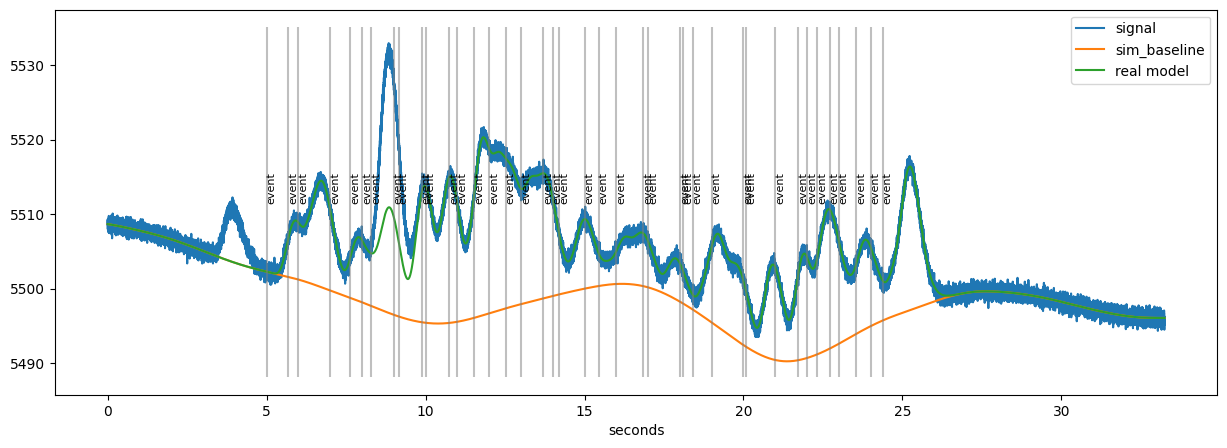

In [2]:
faked=pp.create_fake_pupildata(ntrials=20)
plt.figure(figsize=(15,5))
faked.plot()

The orange line is the tonic, baseline-component. At the timing of each event (grey lines), a scaled version of a "response-kernel" (Hoeks & Levelt, 1993) is added. Finally, random noise is added on top of the modeled data. The challenge is to extract both the size of the response as well as the baseline value at each stimulus when only using the raw pupillometric data (the blue line).

## Traditional approaches for disentangling tonic and phasic components

One common way to solve this problem and analyse pupillometric data on the trial-by-trial level is therefore to extract the average pupillometric signal just before a stimulus (as a measure of the baseline signal) and just after the stimulus (as a measure of the pupil's response. In `pypillometry` this functionality is implemented by `PupilData.stat_per_event()` which allows to extract a summary of the signal relative to the events in the dataset.

For example, the following code extracts
- the average signal in the time-window from 200 ms before each event until the timing of the event itself (`0`) as baseline
- the average signal in the time-window from 800 ms after each event until 1200 ms after the event as a measure of the response 

often, the baseline is subtracted from the response:

In [3]:
baseline=faked.stat_per_event( (-200, 0   ) )
response=faked.stat_per_event( ( 800, 1200) )-baseline
baseline,response

(array([5500.56515638, 5509.56503514, 5505.1305654 , 5505.58670786,
        5532.68266103, 5511.59701815, 5525.41677883, 5503.82262254,
        5522.53790134, 5513.09265628, 5505.33927185, 5514.86643245,
        5512.1684625 , 5524.29129093, 5534.80567185, 5515.18542902,
        5514.13734023, 5507.49263465, 5516.95359107, 5518.51300527,
        5502.73976948, 5505.57378147, 5505.56045352, 5519.91456927,
        5509.3941475 , 5512.94693075, 5502.59509483, 5509.74297856,
        5518.75210639, 5503.21585722, 5512.47698792, 5522.8453116 ,
        5521.46205695, 5525.64015504, 5509.74327272, 5506.72779301,
        5512.27484191, 5517.6846295 , 5522.48397992, 5517.80347458]),
 array([  9.98461655,  -4.99864845,   0.42726416,  24.49363307,
        -19.41832247,  10.01091518, -20.29265814,  17.25116065,
         -7.60631407,  -8.41636626,  10.76844416,  -3.88367907,
         10.23516969,   5.61337868, -19.53140635,  -2.33528928,
         -5.38115079,  11.75266296,   1.34089933,  -2.39554707

Note that `PupilData.stat_per_event()` supports selecting specific events, any summary-function (default is `numpy.mean`) and has functionality for handling missing data in the used time-windows, e.g.:

In [4]:
faked.stat_per_event( (-200,0), event_select="event", statfct=np.median, return_missing="nmiss")

(array([5500.57469867, 5509.56155148, 5505.14088376, 5505.5962155 ,
        5532.74450742, 5511.5497309 , 5525.53126847, 5503.84263458,
        5522.51638809, 5513.12118851, 5505.3760257 , 5514.93968667,
        5512.23951918, 5524.36564923, 5535.07116513, 5515.28880956,
        5514.16906605, 5507.50759718, 5516.84940393, 5518.54110169,
        5502.70723911, 5505.58973883, 5505.58973883, 5519.87836847,
        5509.37193703, 5512.73641174, 5502.61046823, 5509.5477723 ,
        5518.8241705 , 5503.16212078, 5512.51075884, 5523.16039138,
        5521.92420769, 5525.61114133, 5509.62371445, 5506.67330874,
        5512.29669153, 5517.6877734 , 5522.59228283, 5517.95132977]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]))

## Advanced methods for tonic/phasic component estimation

The simple method detailed above is appealing for its simplicity but has severe limitations. Most importantly, multiple overlapping pupillary responses can "look like" baseline-fluctuations when added together, thereby artificially inflating baseline-estimates particularly in cases where events are spaced closely in time ("fast paradigms"). For that reason, we developed specialized algorithms to disentangle tonic and phasic components of the pupillometric signal.

This algorithm uses an iterative procedure to remove an initial estimate of the responses from the signal to continue to estimate the underlying baseline. Details about how this algorithm works and which parameters it supports are available in [this notebook](symp_talk_uit2019.html) and will be available in a forthcoming publication.

In practice, the functionality is implemented in `PupilData.estimate_baseline()` and `PupilData.estimate_response()`. The response-estimation depends on the estimated baseline, hence the `estimate_baseline()` function should always be called first. In order to increase speed, we filter the data and downsample it to 50 Hz before running the baseline- and response-estimation functions

In [3]:
d=faked.lowpass_filter(cutoff=5)\
    .downsample(fsd=50)\
    .estimate_baseline()\
    .estimate_response()

13:38:00 - cmdstanpy - INFO - compiling stan file /Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/pypillometry/stan/baseline_model_asym_laplac.stan to exe file /Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/pypillometry/stan/baseline_model_asym_laplac
13:38:11 - cmdstanpy - INFO - compiled model executable: /Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/pypillometry/stan/baseline_model_asym_laplac
13:38:11 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
13:38:11 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/pypillometry/stan/baseline_model_asym_laplac.hpp /Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/pypillometry/stan/baseline_model_asym_laplac.stan
Warning in '/Users/mmi041/miniconda3/envs/pypil/lib/python3.11/site-packages/pypillometry/stan/baseline_model_asym_laplac.stan', line 25, column 2: Decla

MSG: optimizing both npar and tmax, might take a while...
....RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02201D+03    |proj g|=  1.00000D+01
......
At iterate    1    f=  4.83098D+03    |proj g|=  1.14786D+01
...
At iterate    2    f=  4.82977D+03    |proj g|=  2.68592D+00
....................................
At iterate    3    f=  4.82861D+03    |proj g|=  1.12658D+01
............................................................
At iterate    4    f=  4.82860D+03    |proj g|=  1.12654D+01
.........................................................
At iterate    5    f=  4.82860D+03    |proj g|=  1.12654D+01
...
At iterate    6    f=  4.82766D+03    |proj g|=  3.16377D+00
....................................
At iterate    7    f=  4.82758D+03    |proj g|=  3.16486D+00
  ys=-1.257E-04  -gs= 3.597E-02 BFGS update SKIPPED
......................


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


...............................................
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9    128     11     1     0   3.103D+00   4.828D+03
  F =   4827.5801130770069     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Here, we allowed the two shape parameters `npar` and `tmax` to vary freely together with the amplitude of the responses. This allows an individualized shape of the pupillary response for each subject (which appears reasonable given the results in Hoeks & Levelt, 1993) but may also take a long time to optimize and potentially results in pathological solutions. In that case, one or both of the parameters can be fixed, for example to reasonable group-level values.

After running these methods, the baseline is stored in the `PupilData.baseline` variable:


In [4]:
d.baseline

array([5506.60211363, 5506.59273533, 5506.5834325 , ..., 5485.23638076,
       5484.3357519 , 5483.75875634])

and the estimated response in `PupilData.response_pars`:

In [5]:
d.response_pars

{'npar': 12.133905825194027,
 'npar_free': True,
 'tmax': 898.7234873463632,
 'tmax_free': True,
 'coef': array([ 6.45214962,  7.60798074,  5.78462218, 28.48222728,  8.72415534,
         1.63101216,  8.68602903,  3.46276526,  8.75802417,  3.99823936,
         2.43358659,  6.28152258,  5.13713739,  5.93687642,  7.76130068,
         9.48397437,  5.13520711,  3.96577155,  6.35544905,  4.47026992,
         8.15474015,  7.52196319,  0.        ,  0.87014452,  7.6776929 ,
         5.11455988,  6.19950358,  7.42388264,  0.84350501,  5.67189297,
         4.80263714,  1.47131671,  0.        , 10.11872253,  1.68426276,
         0.        ,  5.86399889,  2.06501056,  0.46787953, 17.56992387]),
 'bounds': {'npar': (1, 20), 'tmax': (100, 2000)}}

The resulting baseline-estimation and the estimated full model (baseline+response) can be plotted:


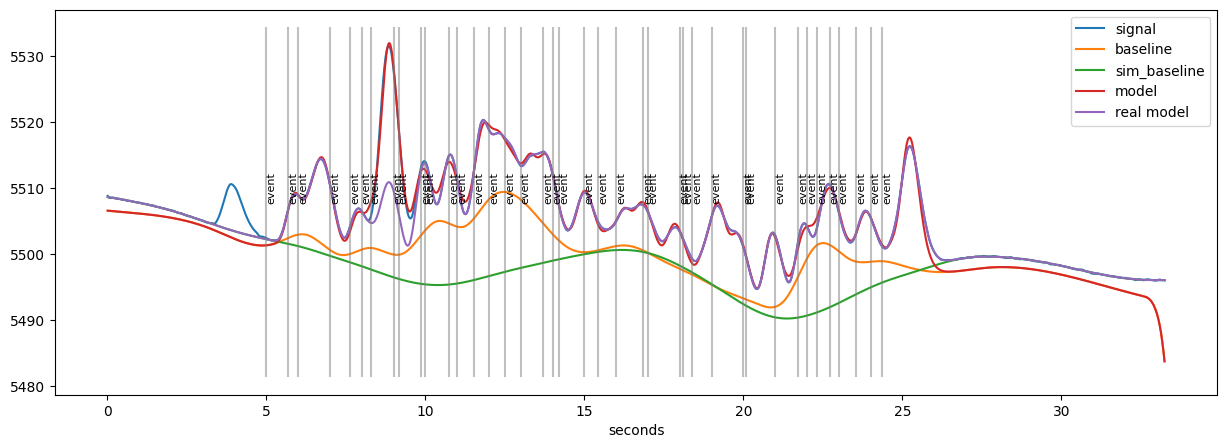

In [6]:
plt.figure(figsize=(15,5))
d.plot()

The orange curve (estimated baseline) is still more wiggly than the real baseline (green) but give a considerable better estimate than a traditional method. The overall fit of the model (red) is excellent (which is to be expected, as this is simulated data). The misfit comes from randomly interspersed "spurious" events in the randomly generated data.

We can quantify how well the novel baseline-estimation works relative to the traditional method by comparing it to the "ground-truth" which is available for artificial data.

We calculate the ground-truth and the traditional and novel estimates for each event-onset (=trial):

In [8]:
real_baseline=pp.stat_event_interval(d.tx, d.sim_baseline, d.event_onsets, [0,0])
real_response=d.sim_response_coef

traditional_baseline=d.stat_per_event( (-200,0) )
traditional_response=d.stat_per_event( ( 800,1200) )-traditional_baseline

novel_baseline=pp.stat_event_interval(d.tx, d.baseline, d.event_onsets, [0,0])
novel_response=d.response_pars["coef"]

And compare them by means of the correlation of the estimated and mean values:

In [9]:
print("Traditional method:")
print("Baseline: Corr(trad,real)=",scipy.stats.pearsonr(traditional_baseline, real_baseline)[0])
print("Response: Corr(trad,real)=",scipy.stats.pearsonr(traditional_response, real_response)[0])
print("\n")
print("Novel method:")
print("Baseline: Corr(nov, real)=",scipy.stats.pearsonr(novel_baseline, real_baseline)[0])
print("Response: Corr(nov, real)=",scipy.stats.pearsonr(novel_response, real_response)[0])

Traditional method:
Baseline: Corr(trad,real)= 0.4040649388855033
Response: Corr(trad,real)= 0.24671355233788791


Novel method:
Baseline: Corr(nov, real)= 0.5735089277947327
Response: Corr(nov, real)= 0.567976353827413


We see that the correlations are much higher for the novel method when compared to the traditional methods. More sophisticated simulation studies are reported in [this notebook](symp_talk_uit2019.html).


The parameters for the baseline-estimation function are described in the API-documentation for `pypillometry.baseline.baseline_envelope_iter_bspline()` and, in more detail, in [this notebook](symp_talk_uit2019.html).

The parameters for the response-estimation function are described in the API-documentation for `pypillometry.pupil.pupil_response()`.